ant or bee classification using resnet18
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [13]:
# imports
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import torchvision.transforms.functional as TF

plt.ion()

In [3]:
# data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
    ])
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['val', 'train']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['val', 'train']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['val', 'train']}
class_names = image_datasets['train'].classes
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

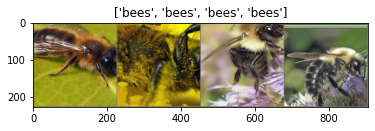

In [4]:
# look at some example from the dataset
def imshow(img, title=None):
    img = img.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
# get a batch
inputs, classes = next(iter(dataloaders['train']))

# make into grid
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [5]:
# define taining

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        # train and validate each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero gradients at start
                optimizer.zero_grad()
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} loss: {:.4f} acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy if is good
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val accuracy: {:4f}'.format(best_acc))
    
    # return best weights
    model.load_state_dict(best_model_wts)
    return model
        
        

In [6]:
# visualize some predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
# build model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# change fully connected layer to our number of classes
model_ft.fc = nn.Linear(num_ftrs, 2) # len(class_names) would also work

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# decay lr
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
# this cell trains, will take a long time!
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

In [11]:
visualize_model(model_ft)

In [8]:
# build model but block training on most layers, i.e. use convnet as a fixed feautre extractor
model_fc_only = models.resnet18(pretrained=True)

# turn off training
for param in model_fc_only.parameters():
    param.requires_grad = False
    

num_ftrs = model_fc_only.fc.in_features

# change fully connected layer to our number of classes
model_fc_only.fc = nn.Linear(num_ftrs, 2) # len(class_names) would also work

model_fc_only = model_fc_only.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_fc_only.parameters(), lr=0.001, momentum=0.9)

# decay lr
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
# this cell trains, will take not too long because it is fc only
model_fc_only = train_model(model_fc_only, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------
train loss: 0.5048 acc: 0.7623
val loss: 0.3156 acc: 0.8947

Epoch 2/20
----------
train loss: 0.4923 acc: 0.7828
val loss: 0.2738 acc: 0.8882

Epoch 3/20
----------
train loss: 0.4220 acc: 0.8320
val loss: 0.2492 acc: 0.9276

Epoch 4/20
----------
train loss: 0.3313 acc: 0.8607
val loss: 0.1898 acc: 0.9605

Epoch 5/20
----------
train loss: 0.3286 acc: 0.8811
val loss: 0.1879 acc: 0.9605

Epoch 6/20
----------
train loss: 0.4086 acc: 0.8197
val loss: 0.1980 acc: 0.9605

Epoch 7/20
----------
train loss: 0.3134 acc: 0.8607
val loss: 0.1869 acc: 0.9605

Epoch 8/20
----------
train loss: 0.2530 acc: 0.8852
val loss: 0.2101 acc: 0.9539

Epoch 9/20
----------
train loss: 0.3326 acc: 0.8607
val loss: 0.1954 acc: 0.9605

Epoch 10/20
----------
train loss: 0.3587 acc: 0.8607
val loss: 0.1814 acc: 0.9474

Epoch 11/20
----------
train loss: 0.2617 acc: 0.8852
val loss: 0.2191 acc: 0.9408

Epoch 12/20
----------
train loss: 0.2439 acc: 0.9180
val loss: 0.1840 acc: 0.9539

E

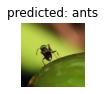

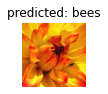

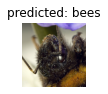

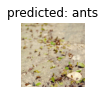

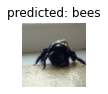

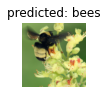

In [25]:
visualize_model(model_fc_only)

In [22]:
def test_img(path):
    image = Image.open(path)
    x = TF.to_tensor(image)
    x.unsqueeze_(0)
#     print(x.shape)

    output = model_fc_only(x)
    print(output)
    print(torch.max(output, 1))

test_img('./data/hymenoptera_data/single_test/bee.jpeg')
test_img('./data/hymenoptera_data/single_test/ant.jpeg')

tensor([[0.2438, 0.0893]], grad_fn=<AddmmBackward0>)
torch.return_types.max(
values=tensor([0.2438], grad_fn=<MaxBackward0>),
indices=tensor([0]))
tensor([[ 1.8569, -1.5289]], grad_fn=<AddmmBackward0>)
torch.return_types.max(
values=tensor([1.8569], grad_fn=<MaxBackward0>),
indices=tensor([0]))


In [24]:
test_img('./data/hymenoptera_data/single_test/bee.jpeg')
test_img('./data/hymenoptera_data/single_test/ant.jpeg')

tensor([[0.3039, 0.0658]], grad_fn=<AddmmBackward0>)
torch.return_types.max(
values=tensor([0.3039], grad_fn=<MaxBackward0>),
indices=tensor([0]))
tensor([[ 2.0566, -1.6810]], grad_fn=<AddmmBackward0>)
torch.return_types.max(
values=tensor([2.0566], grad_fn=<MaxBackward0>),
indices=tensor([0]))
